In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

from math import sqrt
from torch import optim
from torch.utils.data import Dataset, DataLoader


import os
import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Proyecto_CD/"

Mounted at /content/drive


In [ ]:
FGJ_carpetas = pd.read_csv(path+'FGJ_carpetas_homo.csv', parse_dates=["fecha_hechos"]) 
FGJ_carpetas.index = pd.DatetimeIndex(FGJ_carpetas.fecha_hechos)
top_cat=FGJ_carpetas['categoria_delito_homo'].value_counts().index[1:11]
cat = top_cat[top_cat!="HECHO NO DELICTIVO"]
ts_hour_edo = FGJ_carpetas.pivot_table("delito",columns="categoria_delito_homo", 
        index = FGJ_carpetas['fecha_hechos'].dt.to_period('H'), 
                        aggfunc=np.size, fill_value=0)
delito_typ1 = FGJ_carpetas[(FGJ_carpetas["categoria_delito_homo"] == "DELITO DE BAJO IMPACTO")|(FGJ_carpetas["categoria_delito_homo"] == "HECHO NO DELICTIVO")]#['fecha_hechos'].resample('H').count()
delitos_hour = delito_typ1.pivot_table('delito',columns="categoria_delito_homo", 
      index = delito_typ1['fecha_hechos'].dt.to_period('H'), 
                        aggfunc=np.size, fill_value=0)
uk_ts = pd.concat([ts_hour_edo.loc[:,cat], delitos_hour], axis=1)
uk_ts.iloc[np.where(uk_ts.isna())]=0

In [ ]:
uk_ts

,ROBO DE OBJETOS,VIOLENCIA FAMILIAR,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,FRAUDE,ROBO A NEGOCIO SIN VIOLENCIA,AMENAZAS,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,ROBO A CASA SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO
fecha_hechos,,,,,,,,,,,
2016-01-01 00:00,1,3,1,9,0,3,0,1,0,7.0,1.0
2016-01-01 01:00,1,3,1,0,0,3,1,1,0,6.0,0.0
2016-01-01 02:00,1,3,0,0,0,0,1,2,0,2.0,0.0
2016-01-01 03:00,0,2,0,0,0,0,0,1,0,1.0,3.0
2016-01-01 04:00,0,5,0,0,2,0,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 17:00,0,2,0,1,1,2,0,0,1,2.0,1.0
2022-06-30 18:00,1,1,2,0,1,0,0,0,0,7.0,0.0
2022-06-30 19:00,0,2,0,0,3,2,0,0,0,4.0,0.0


In [ ]:
import holidays
from datetime import date
mex_holidays  = holidays.MEX()
atib_holidays = ts_hour_edo.index.to_series().apply(lambda x: date(x.year, x.month, x.day) in mex_holidays).values
atib_hour = ts_hour_edo.index.hour.values
atib_week = ts_hour_edo.index.week.values
atib_month = ts_hour_edo.index.month.values
atib_day = ts_hour_edo.index.day_of_week.values

In [ ]:
data = pd.concat([uk_ts,
           pd.DataFrame(np.transpose([1*atib_holidays,atib_hour,atib_week,
                atib_month,atib_day]),index = ts_hour_edo.index,
                columns=["Holidays","Hora","Semana","Mes","Day"])], axis=1)

In [ ]:
data.iloc[:,11:] = data.iloc[:,11:].astype(int)
data.iloc[:,:11] = data.iloc[:,:11].astype(float)
data.info()

In [ ]:
df = data.iloc[:,[0,9,10,11,12,13,14,15]]
df = uk_ts
df

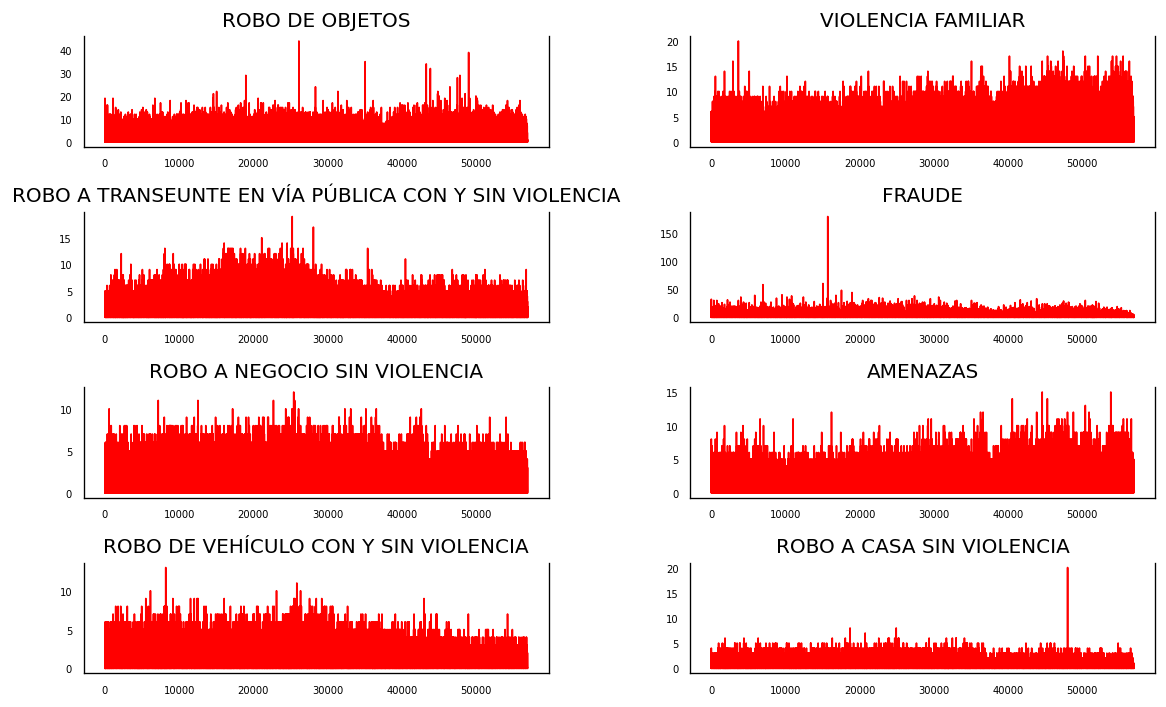

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_ = df[df.columns[i]]
    ax.plot(data_.values, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/p

,ROBO DE OBJETOS_x,VIOLENCIA FAMILIAR_x,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA_x,FRAUDE_x,ROBO A NEGOCIO SIN VIOLENCIA_x,AMENAZAS_x,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA_x,ROBO A CASA SIN VIOLENCIA_x,ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA_x,DELITO DE BAJO IMPACTO_x,HECHO NO DELICTIVO_x
ROBO DE OBJETOS_y,0.9372,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
VIOLENCIA FAMILIAR_y,0.0000,1.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA_y,0.0000,0.0,1.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
FRAUDE_y,0.0000,0.0,0.0,1.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
ROBO A NEGOCIO SIN VIOLENCIA_y,0.0000,0.0,0.0,0.0,0.8777,0.0,0.0,0.0,0.0,0.0,0.0
AMENAZAS_y,0.0000,0.0,0.0,0.0,0.0000,1.0,0.0,0.0,0.0,0.0,0.0
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA_y,0.0000,0.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,0.0,0.0
ROBO A CASA SIN VIOLENCIA_y,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,1.0,0.0,0.0,0.0
ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA_y,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,1.0,0.0,0.0
DELITO DE BAJO IMPACTO_y,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ROBO DE OBJETOS ::  78058.22  > 263.2603  =>   True
VIOLENCIA FAMILIAR ::  64280.74  > 219.4051  =>   True
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA ::  53759.33  > 179.5199  =>   True
FRAUDE ::  44656.72  > 143.6691  =>   True
ROBO A NEGOCIO SIN VIOLENCIA ::  35995.97  > 111.7797  =>   True
AMENAZAS ::  27756.37  > 83.9383   =>   True
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA ::  20199.34  > 60.0627   =>   True
ROBO A CASA SIN VIOLENCIA ::  13373.24  > 40.1749   =>   True
ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA ::  7364.67   > 24.2761   =>   True
DELITO DE BAJO IMPACTO ::  3224.28   > 12.3212   =>   True
HECHO NO DELICTIVO ::  789.8     > 4.1296    =>   True


In [ ]:
nobs = 48
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(56892, 11)
(48, 11)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ROBO DE OBJETOS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.1481
 No. Lags Chosen       = 59
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DELITO DE BAJO IMPACTO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.1811
 No. Lags Chosen       = 54
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HECHO NO DELICTIVO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [ ]:
df_differenced = df_train.diff().dropna()
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [ ]:
x = model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.22,11.22,7.472e+04,11.22
1,10.07,10.09,2.359e+04,10.08
2,9.673,9.713,1.588e+04,9.685
3,9.549,9.608,1.403e+04,9.567
4,9.453,9.530,1.274e+04,9.477
5,9.378,9.474,1.182e+04,9.408
6,9.309,9.425,1.104e+04,9.345
7,9.229,9.364,1.019e+04,9.271
8,9.153,9.307,9446.,9.201
9,9.102,9.275,8970.,9.155


In [ ]:
model_fitted = model.fit(24)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Dec, 2022
Time:                     16:51:23
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    8.54076
Nobs:                     56916.0    HQIC:                   8.22513
Log likelihood:      -1.11546e+06    FPE:                    3237.04
AIC:                      8.08241    Det(Omega_mle):         3075.79
--------------------------------------------------------------------
Results for equation ROBO DE OBJETOS
                                                                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------------------------------------
const                                                                       0.479043         0.072382   

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

ROBO DE OBJETOS : 1.97
VIOLENCIA FAMILIAR : 2.0
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA : 2.01
FRAUDE : 1.9
ROBO A NEGOCIO SIN VIOLENCIA : 2.0
AMENAZAS : 2.0
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA : 2.0
ROBO A CASA SIN VIOLENCIA : 2.0
ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA : 2.0
DELITO DE BAJO IMPACTO : 1.91
HECHO NO DELICTIVO : 1.98


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

24


array([[4., 5., 1., 0., 2., 0., 2., 1., 0., 7., 1.],
       [1., 4., 1., 0., 0., 1., 0., 1., 1., 6., 0.],
       [1., 2., 2., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.],
       [0., 2., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
       [3., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [4., 2., 0., 0., 0., 0., 0., 1., 0., 2., 0.],
       [2., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0.],
       [4., 2., 1., 0., 2., 2., 0., 0., 0., 3., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 9., 0.],
       [1., 0., 0., 2., 1., 0., 1., 1., 0., 3., 0.],
       [2., 5., 0., 0., 2., 0., 1., 0., 0., 3., 1.],
       [0., 3., 3., 0., 1., 1., 0., 0., 1., 4., 0.],
       [0., 3., 1., 1., 2., 3., 0., 0., 0., 4., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 5., 0.],
       [0., 3., 0., 0., 2., 2., 0., 0., 0., 4., 0.],
       [0., 2., 0., 1., 1., 0., 0., 0., 0., 4.

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,ROBO DE OBJETOS_2d,VIOLENCIA FAMILIAR_2d,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA_2d,FRAUDE_2d,ROBO A NEGOCIO SIN VIOLENCIA_2d,AMENAZAS_2d,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA_2d,ROBO A CASA SIN VIOLENCIA_2d,ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA_2d,DELITO DE BAJO IMPACTO_2d,HECHO NO DELICTIVO_2d
fecha_hechos,,,,,,,,,,,
2022-06-28 21:00,1.477636,2.332235,0.579538,1.169546,0.900692,0.930399,0.803535,0.499028,0.109070,3.874084,0.805379
2022-06-28 22:00,1.368970,2.142854,0.585080,0.528715,0.779321,0.779291,0.792384,0.353020,0.078153,2.757638,0.417083
2022-06-28 23:00,1.399476,1.699344,0.519910,0.084296,0.707282,0.571567,0.755072,0.334508,0.059315,2.208789,0.340640
2022-06-29 00:00,1.595609,1.453245,0.472785,0.447244,0.639621,0.433962,0.675864,0.321919,0.062310,2.319581,0.634598
2022-06-29 01:00,1.649772,1.531381,0.405490,0.835695,0.688821,0.507663,0.732669,0.369849,0.049782,2.844199,0.456475
2022-06-29 02:00,1.812396,1.481041,0.305628,0.722949,0.654137,0.483555,0.672395,0.323286,0.013374,2.873827,0.427680
2022-06-29 03:00,1.862224,1.463939,0.323108,0.610994,0.690747,0.486096,0.684694,0.332991,-0.047166,2.358994,0.511513
2022-06-29 04:00,1.878782,1.663752,0.308175,0.630397,0.706296,0.566010,0.711957,0.316331,0.073569,2.680535,0.382271
2022-06-29 05:00,1.989540,1.838493,0.502446,0.575701,0.862203,0.759629,0.669025,0.374345,0.107525,2.990801,0.288493


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


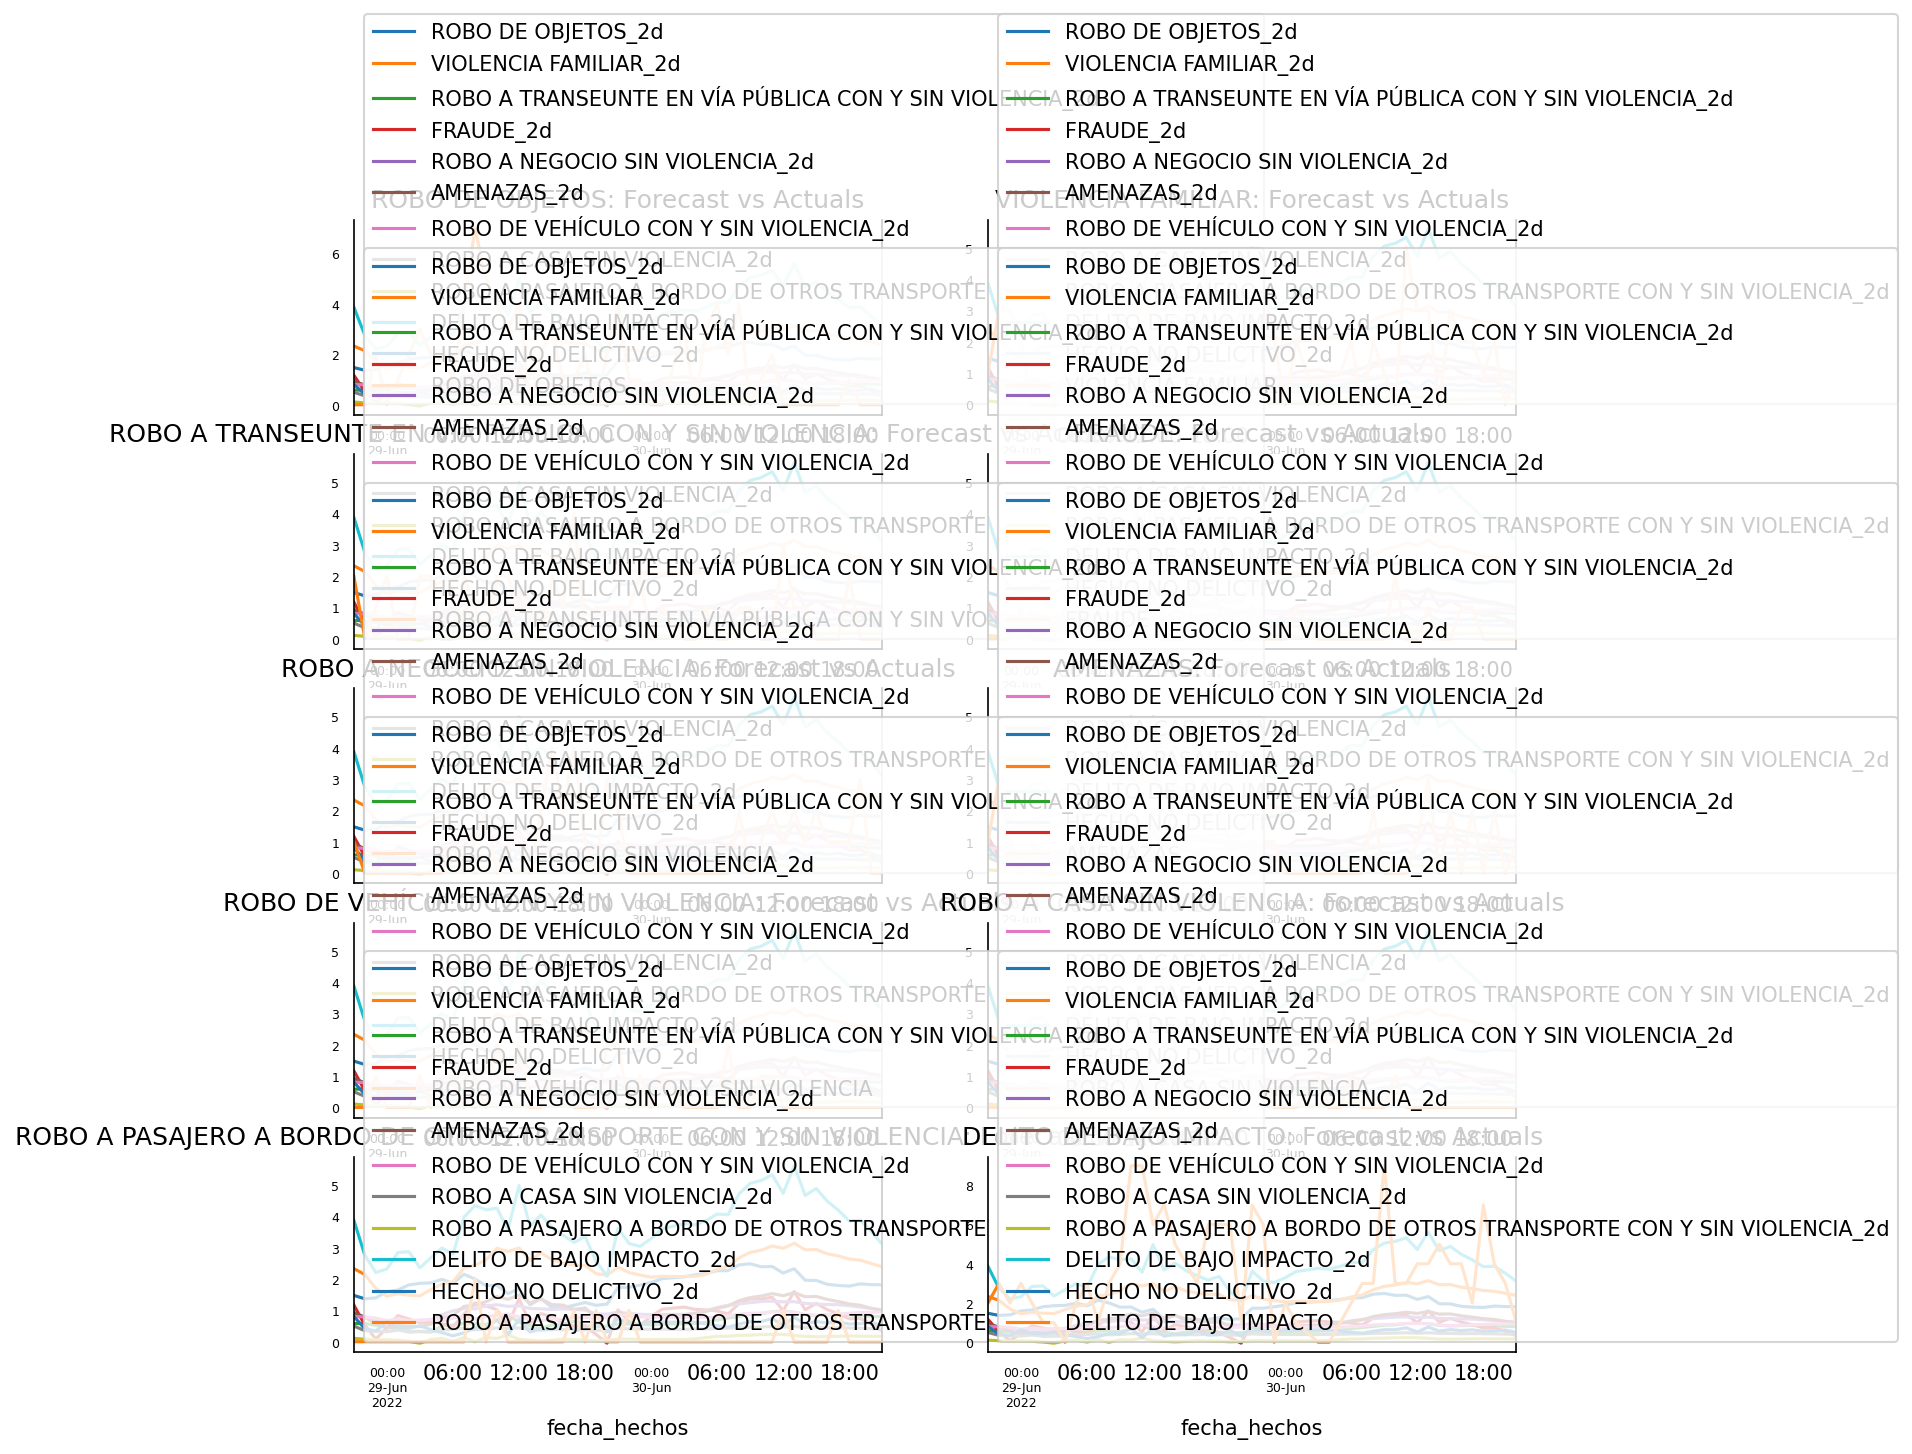

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    #df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_forecast.plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


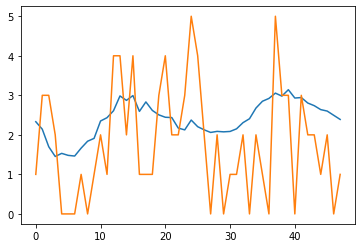

In [ ]:
plt.plot(df_forecast.iloc[:,1].values)
plt.plot(df_test.iloc[:,1].values)

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp


NameError: ignored